In [53]:
# This is an IMM Kalman filter tracker in 2D


import numpy as np
import matplotlib.pyplot as plt
from numpy import matlib
import numpy.random as random

In [54]:
def Kalman_filter_z_S (z, x0, P0, F, Q, H, R, dt):
    
    
    xh =x0
    Ph =P0
    
    # prediction
    x_pred = F@xh
    P_pred = F@Ph@(F.T) + Q
        
            
    #update
    H1=H.reshape(2,4)
    y = z - H1@x_pred
    S = H1@P_pred@(H1.T)+R
    K = P_pred@(H1.T)@(np.linalg.inv(S))
    #K = P_pred@(H.T)/S
    K1 = K.reshape(4,2)
    xh = x_pred + K1@y
    #xh = x_pred + K1*y

    IdM = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    Ph = (IdM - K1@H1)@P_pred
    #Ph = P_pred - K1@S@(K1.T)

        
    return xh, Ph, y, S


In [60]:
def IMM_Kalman_filter (data, x0, P0, mu0_1, mu0_2, F, Q1, Q2, TPM, H, R, dt):
    
    xh_1 =x0
    Ph_1 =P0
    
    xh_2 =x0
    Ph_2 =P0
    
    mu_1 = mu0_1
    mu_2 = mu0_2
    
    xhh_IMM = []
    
    for z in data:
        
        # Calculating Mixing Probabilities
    
        c1 = TPM[0,0]*mu_1 + TPM[0,1]*mu_2
        c2 = TPM[1,0]*mu_1 + TPM[1,1]*mu_2
    
        mu_1g1 = (TPM[0,0]*mu_1)/c1
        mu_1g2 = (TPM[0,1]*mu_2)/c1
        
        mu_2g1 = (TPM[1,0]*mu_1)/c2
        mu_2g2 = (TPM[1,1]*mu_2)/c2
        
        # Mixing
        
        xi_1 = xh_1*mu_1g1 + xh_2*mu_1g2
        Pi_1 = (Ph_1 + (xh_1-xi_1)@(xh_1-xi_1).T)*mu_1g1 + (Ph_2 + (xh_2-xi_1)@(xh_2-xi_1).T)*mu_1g2
        
        xi_2 = xh_1*mu_2g1 + xh_2*mu_2g2
        Pi_2 = (Ph_1 + (xh_1-xi_2)@(xh_1-xi_2).T)*mu_2g1 + (Ph_2 + (xh_2-xi_2)@(xh_2-xi_2).T)*mu_2g2
            
    
        #Model-Matching Filtering
       
        # Call Kalman filter 1
    
        xhh_f1, Phh_f1, zih_f1, S_f1 = Kalman_filter_z_S (z=z, x0=xi_1, P0=Pi_1, F=F, Q=Q1, H=H, R=R, dt=dt)
        
        xh_1 = xhh_f1
        Ph_1 = Phh_f1
            
        # Call Kalman filter 2
    
        xhh_f2, Phh_f2, zih_f2, S_f2 = Kalman_filter_z_S (z=z, x0=xi_2, P0=Pi_2, F=F, Q=Q2, H=H, R=R, dt=dt)
        
        xh_2 = xhh_f2
        Ph_2 = Phh_f2
        
    
        # Model Probability Update
        
    
        a1 = (-0.5)*(zih_f1.T)@(np.linalg.inv(S_f1))@(zih_f1)
        d1 = np.sqrt(((2*np.pi)**2*(np.linalg.det(S_f1))))
        G_1 = np.exp(a1)/d1
                
        a2 = (-0.5)*(zih_f2.T)@(np.linalg.inv(S_f2))@(zih_f2)
        d2 = np.sqrt(((2*np.pi)**2*(np.linalg.det(S_f2))))
        G_2 = np.exp(a2)/d2
                
        c = G_1*c1 + G_2*c2
                
        mu_1 = G_1*c1/c
        mu_2 = G_2*c2/c
                
        
        # Estimate and Covariance Combination
                
        xh = xhh_f1*mu_1 + xhh_f2*mu_2
        Ph = (Phh_f1+(xhh_f1-xh)@(xhh_f1-xh).T)*mu_1 + (Phh_f2+(xhh_f2-xh)@(xhh_f2-xh).T)*mu_2      
           
    
        xhh_IMM.append(xh)
        
    return xhh_IMM


In [61]:
def gen_data_IMM (x0, P0, F, Q, t_m, acc_x, acc_y, t_t, duration, H, R, dt):
    
    x_temp0 = np.random.multivariate_normal([x0[0,0], x0[1,0], x0[2,0], x0[3,0]], P0, 1)
    x_temp1 = x_temp0.reshape(4,1)
    
    #x_temp1 = x0
    
    x_truth = []
    z = []
    for i in range(duration):
        
        if  i < t_m:
        
            w = np.random.multivariate_normal([0, 0, 0, 0], Q, 1)
            w2 = w.reshape(4,1)
            x_temp2 = F@x_temp1 + w2
            
            x_truth.append(x_temp2)
            
            v = np.random.multivariate_normal([0, 0], R, 1)
            v2 = v.reshape(2,1)
            z_m = H@x_temp2 + v2
            z_m2 = z_m.reshape(2,1)
        
            x_temp1 = x_temp2
        
        elif i >= t_m and i < t_t:
        
            w = np.random.multivariate_normal([0, 0, 0, 0], Q,1)
            w2 = w.reshape(4,1)
            
            acc_v_1 = np.array([acc_x*0.5*(dt**2), acc_x*dt, acc_y*0.5*(dt**2), acc_y*dt])
            acc_v = acc_v_1.reshape(4,1)
            x_temp2 = F@x_temp1 + acc_v + w2
            
            x_truth.append(x_temp2)
            
            v = np.random.multivariate_normal([0, 0], R,1)
            v2 = v.reshape(2,1)
            z_m = H@x_temp2 + v2
            z_m2 = z_m.reshape(2,1)
        
            x_temp1 = x_temp2
            
        elif i >= t_t:
        
            w = np.random.multivariate_normal([0, 0, 0, 0], Q,1)
            w2 = w.reshape(4,1)
            
            x_temp2 = F@x_temp1 + w2
            
            x_truth.append(x_temp2)
            
            v = np.random.multivariate_normal([0, 0], R,1)
            v2 = v.reshape(2,1)
            z_m = H@x_temp2 + v2
            z_m2 = z_m.reshape(2,1)
        
            x_temp1 = x_temp2
        
        z.append(z_m2)
        
    return x_truth, z

In [62]:
x0 = np.array([[100], [-5], [100], [5]], dtype=np.float)
P0 = np.array([[100000, 1, 0, 0], [1, 1000, 0, 0], [0, 0, 100000, 1], [0, 0, 1, 1000]], dtype=np.float)
dt = 1;
F = np.array([[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0, 0, 0, 1]], dtype=np.float)
duration = 100
dt = 1
t_m = 30
t_t = 60
acc_x = 1
acc_y = 1
Q = 0.001*np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=np.float)
R = np.array([[100, 0], [0, 100]], dtype=np.float)
H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]], dtype=np.float)
mu0_1 = 0.5
mu0_2 = 0.5
Q1 = 0.001*np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=np.float)
Q2 = 10*np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=np.float)
TPM = np.array([[0.95, 0.05], [0.05, 0.95]], dtype=np.float)
#TPM = TPM1.reshape(2,2) 
MC=100

In [63]:
SEp = np.zeros(duration)
SEp_z = np.zeros(duration)
SEv = np.zeros(duration)

for i in range(MC):
        x_truth1, obs1 = gen_data_IMM (x0=x0, P0=P0, F=F, Q=Q, t_m=t_m, acc_x=acc_x, acc_y=acc_y, t_t=t_t, duration=duration, H=H, R=R, dt=dt)
        obs = np.asarray(obs1)
        x_truth = np.asarray(x_truth1)
        xhhh1 = IMM_Kalman_filter (data=obs, x0=x0, P0=P0, mu0_1=mu0_1, mu0_2=mu0_2, F=F, Q1=Q1, Q2=Q2, TPM=TPM, H=H, R=R, dt=dt)   
        xhhh = np.asarray(xhhh1)
        
        SE1p=[]
        SE1p_z=[]
        SE1v=[]
        for j in range(duration):
                se1_p = (xhhh[j,0,0]-x_truth[j,0,0])**2 + (xhhh[j,2,0]-x_truth[j,2,0])**2
                se1_p_z = (obs[j,0,0]-x_truth[j,0,0])**2 + (obs[j,1,0]-x_truth[j,2,0])**2
                se1_v = (xhhh[j,1,0]-x_truth[j,1,0])**2 + (xhhh[j,3,0]-x_truth[j,3,0])**2
                SE1p.append(se1_p)
                SE1p_z.append(se1_p_z)
                SE1v.append(se1_v)
                
                
        SEp = SEp + SE1p
        SEp_z = SEp_z + SE1p_z
        SEv = SEv + SE1v

        
MSEp1 = SEp/MC
MSEp_z1 = SEp_z/MC
MSEv1 = SEv/MC

MSEp = np.asarray(MSEp1)
MSEp_z1 = np.asarray(MSEp_z1)
MSEv = np.asarray(MSEv1)

RMSEp = np.sqrt(MSEp)
RMSEp_z1 = np.sqrt(MSEp_z1)
RMSEv = np.sqrt(MSEv)

#MSEp = MSEpp.reshape(1,100)
#MSEp_z = MSEpp_z1.reshape(1,100)
#MSEv = MSEvv.reshape(1,100)



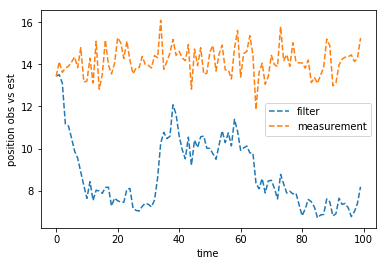

In [64]:
kk1 = np.array(range(duration))
#kk = kk.reshape(1,100)
plt.plot (kk1, RMSEp,'--',label='filter')
plt.plot (kk1, RMSEp_z1,'--',label='measurement')
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('position obs vs est')
plt.show()

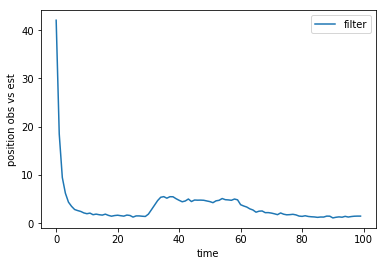

In [65]:
kk1 = np.array(range(duration))
#kk = kk.reshape(1,100)
plt.plot (kk1, RMSEv,label='filter')
#plt.plot (kk1, RMSEp_z,'--',label='measurement')
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('position obs vs est')
plt.show()